# Objectives:
  
In this short project, we derived zero rates from market ZAR swap rate quotes. Additionally, we implemented a methodology to accommodate jumps and track daily fluctuations in swap rates.

                  date  discount factor
0   October 23rd, 2025         1.000000
1   October 23rd, 2026         0.938879
2   October 25th, 2027         0.880000
3   October 23rd, 2028         0.825563
4   October 23rd, 2029         0.771315
5   October 23rd, 2030         0.716748
6   October 23rd, 2031         0.662268
7   October 25th, 2032         0.607768
8   October 24th, 2033         0.555664
9   October 23rd, 2034         0.505795
10  October 23rd, 2035         0.458312
11  October 23rd, 2037         0.372108
12  October 23rd, 2040         0.270711
13  October 23rd, 2045         0.165718
14  October 24th, 2050         0.108848
15  October 25th, 2055         0.076895


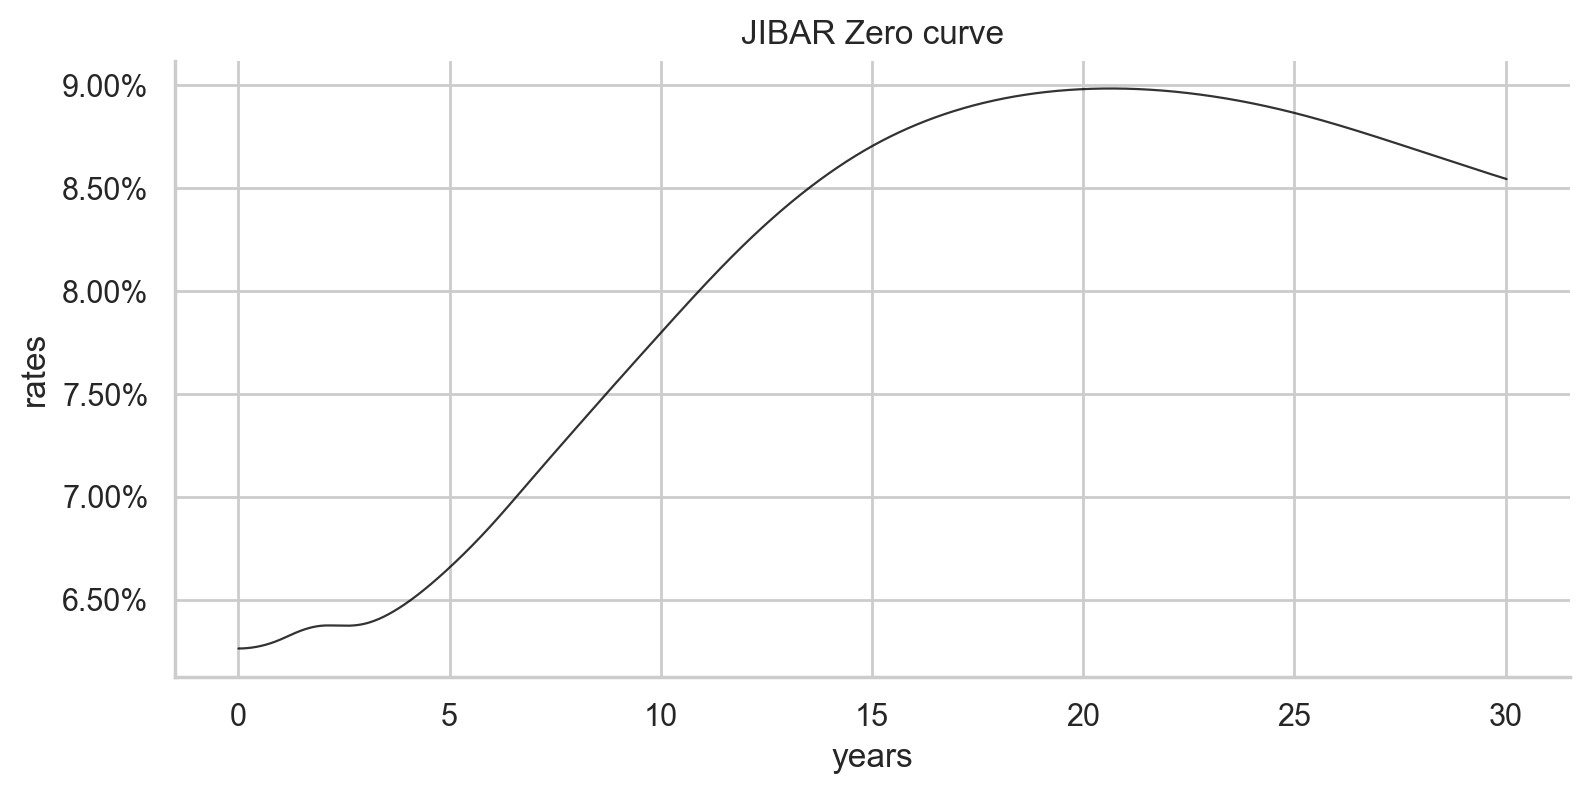

--------------------------------------------------
 Time        Input      Model     Err bp
--------------------------------------------------
  1.0     6.5100%     6.5100%    -0.0000
  2.0     6.5800%     6.5800%    -0.0000
  3.0     6.5900%     6.5900%    -0.0000
  4.0     6.6900%     6.6900%    -0.0000
  5.0     6.8500%     6.8500%    -0.0000
  6.0     7.0400%     7.0400%     0.0000
  7.0     7.2500%     7.2500%     0.0000
  8.0     7.4500%     7.4500%     0.0000
  9.0     7.6400%     7.6400%     0.0000
 10.0     7.8200%     7.8200%    -0.0000
 12.0     8.1400%     8.1400%    -0.0000
 15.0     8.4600%     8.4600%     0.0000
 20.0     8.6600%     8.6600%     0.0000
 25.0     8.6700%     8.6700%    -0.0000
 30.0     8.6100%     8.6100%    -0.0000
--------------------------------------------------


In [1]:
%config InlineBackend.figure_format = 'retina'

import QuantLib as ql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(context='notebook', 
              style='whitegrid',
              palette='dark', 
              color_codes=True, 
              rc={'figure.figsize': [9, 4]})

# evaluation date:
eval_date = ql.Date(23, ql.October, 2025)
ql.Settings.instance().evaluationDate = eval_date

# ZAR IRS Convention
calendar = ql.SouthAfrica()
fixed_freq = ql.Annual
fixed_dc = ql.Actual365Fixed()
fixed_bdc = ql.ModifiedFollowing

# 3M JIBAR index
jibar3m = ql.Jibar(ql.Period(3, ql.Months), ql.YieldTermStructureHandle())


# BlueGamma 3M JIBAR par swap rates (percent) as of 2025-10-23: https://www.bluegamma.io/swap-rates/zar-swap-rates
zar_swap_rate_data = [
    (ql.Period(1,  ql.Years), 6.51),
    (ql.Period(2,  ql.Years), 6.58),
    (ql.Period(3,  ql.Years), 6.59),
    (ql.Period(4,  ql.Years), 6.69),
    (ql.Period(5,  ql.Years), 6.85),
    (ql.Period(6,  ql.Years), 7.04),
    (ql.Period(7,  ql.Years), 7.25),
    (ql.Period(8,  ql.Years), 7.45),
    (ql.Period(9,  ql.Years), 7.64),
    (ql.Period(10, ql.Years), 7.82),
    (ql.Period(12, ql.Years), 8.14),
    (ql.Period(15, ql.Years), 8.46),
    (ql.Period(20, ql.Years), 8.66),
    (ql.Period(25, ql.Years), 8.67),
    (ql.Period(30, ql.Years), 8.61),
]

# build helpers:
helpers = []
swap_quotes = {}
for tenor, quote in zar_swap_rate_data:
    q = ql.SimpleQuote(quote / 100.0)
    swap_quotes[tenor] = q
    h = ql.SwapRateHelper(
        ql.QuoteHandle(q), 
        tenor, 
        calendar, 
        fixed_freq,
        fixed_bdc,
        fixed_dc,
        jibar3m, 
        ql.QuoteHandle(),
        ql.Period(0, ql.Days),
    )
    helpers.append(h)

# piecewise curve (discount), then derive zero/forward curve
curve = ql.PiecewiseLogCubicDiscount(eval_date, helpers, fixed_dc)
curve.enableExtrapolation()

# visualise discount rates
print(pd.DataFrame(curve.nodes(), columns=["date", "discount factor"]))

# plot zero rates
ax = plt.figure().add_subplot(1, 1, 1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda r, pos: f"{r:.2%}"))
times = np.linspace(0.0, curve.maxTime(), 2500)
rates = [curve.zeroRate(t, ql.Continuous).rate() for t in times]
ax.plot(times, rates, color="black", lw=0.8, alpha=0.8)
ax.set_title("JIBAR Zero curve")
ax.set_xlabel("years")
ax.set_ylabel("rates")
sns.despine()
plt.show()

proj = ql.RelinkableYieldTermStructureHandle()
proj.linkTo(curve)  # single-curve: same curve for projection
jibar3m_check = ql.Jibar(ql.Period(3, ql.Months), proj)

engine = ql.DiscountingSwapEngine(ql.YieldTermStructureHandle(curve))

def par_rate(tenor: ql.Period) -> float:
    swap = ql.MakeVanillaSwap(
        tenor,
        jibar3m_check,
        0.0,                          # dummy fixed rate
        ql.Period(0, ql.Days),        # spot-starting
        fixedLegTenor=ql.Period(1, ql.Years),
        fixedLegDayCount=fixed_dc,
        fixedLegConvention=fixed_bdc,
        fixedLegCalendar=calendar,
        pricingEngine=engine
    )
    return 100.0 * swap.fairRate()

zar_swap_rate_data_swaps = [(t, q) for (t, q) in zar_swap_rate_data if t.units() == ql.Years]


print("--"*25)
print(f"{'Time':>5} {'Input':>12} {'Model':>10} {'Err bp':>10}")
print("--"*25)
for t, q in zar_swap_rate_data_swaps:
    pr = par_rate(t)
    err_bp = (pr - q) * 100.0
    print(f"{t.length():5.1f} {q:10.4f}% {pr:10.4f}% {err_bp:10.4f}")
print("--"*25)

# Modifying the curves as quote changes

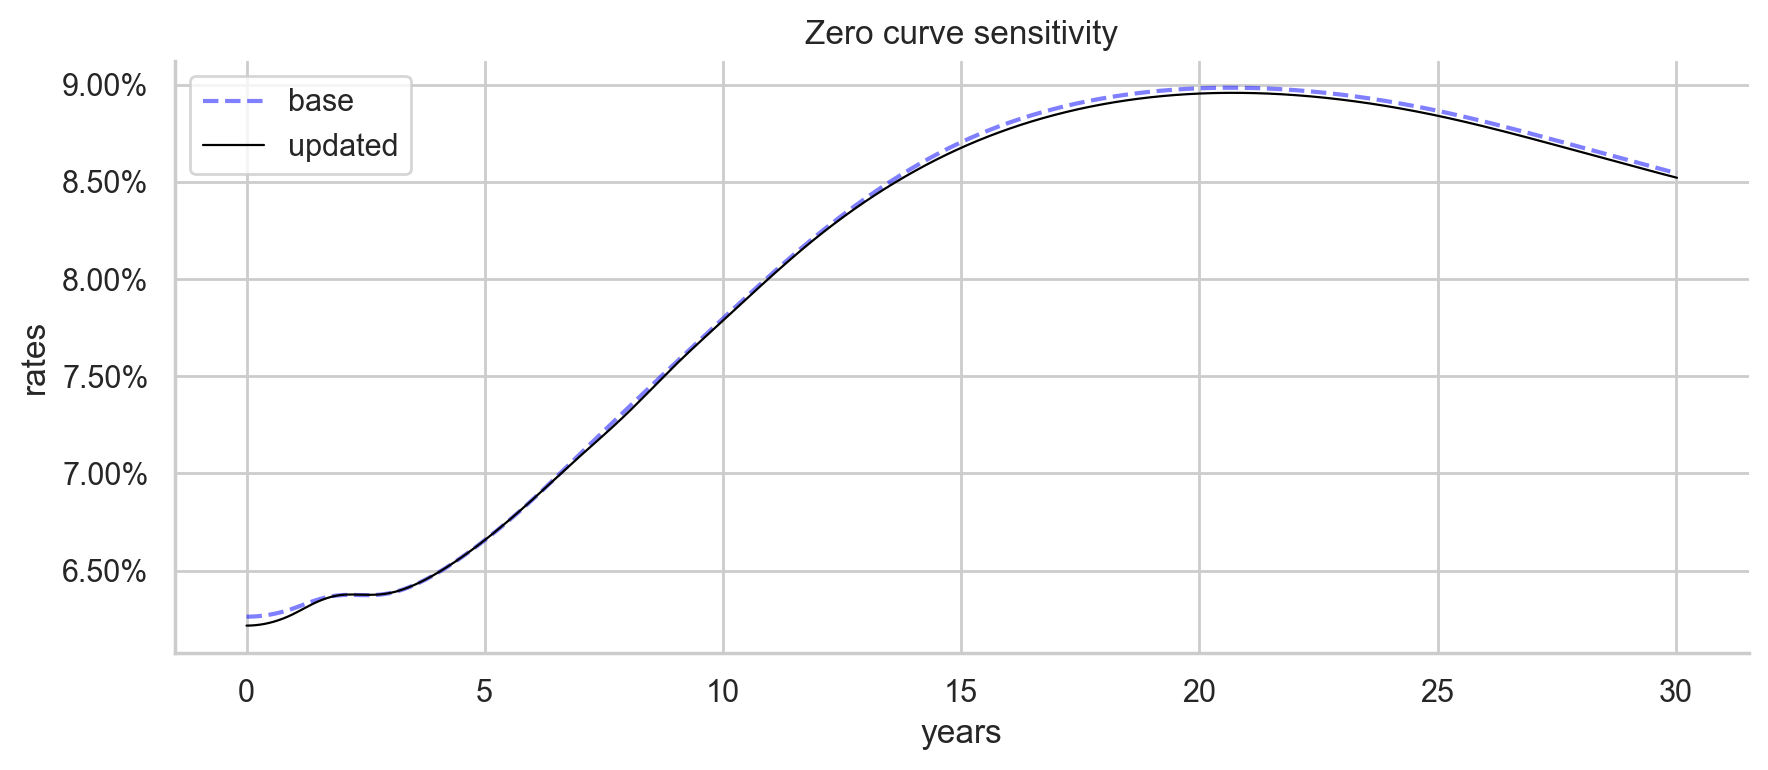

In [2]:
def apply_daily_changes(swap_quotes: dict, bp_changes: list):
    tenors = list(swap_quotes.keys())
    assert len(bp_changes) == len(tenors), "bp_changes length must match number of swap quotes"
    originals = {t: swap_quotes[t].value() for t in tenors}
    for t, d_bp in zip(tenors, bp_changes):
        swap_quotes[t].setValue(originals[t] + d_bp * 1e-4)
    return originals 

def restore_quotes(swap_quotes: dict, originals: dict):
    for t, v in originals.items():
        swap_quotes[t].setValue(v)

bp_changes = [-3.0, 0.0, 0.0, 0.0 , 0.0, 0.0, -1.0, -2.0 , -1.0, -1.0, -1.0, -2.0, -2.0, -2.0, -2.0] # daily changes
originals = apply_daily_changes(swap_quotes, bp_changes)

rates_updated = [curve.zeroRate(t, ql.Continuous).rate() for t in times]

ax = plt.figure().add_subplot(1, 1, 1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda r, pos: f"{r:.2%}"))
ax.plot(times, rates, label="base", color="blue", ls="--", alpha=0.5)
ax.plot(times, rates_updated, label="updated", color="black", lw=0.8)
ax.legend()
ax.set_title("Zero curve sensitivity")
ax.set_xlabel("years")
ax.set_ylabel("rates")
sns.despine()
plt.tight_layout()

restore_quotes(swap_quotes, originals)